In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

plt.style.use(['science','no-latex'])
plt.rcParams["figure.figsize"] = (6.5,6.5)
plt.rcParams['font.size'] =  15


In [2]:
dout="model_compare"

In [3]:
# modules = (fc.eightb.preselection, fc.eightb.preselection_golden, fc.eightb.preselection_gnn_dijet)
# labels = ['t8btag_minmass','golden_gnn','particle_net']

modules = (fc.eightb.preselection,  fc.eightb.preselection_gnn_dijet)
labels = ['t8btag_minmass','particle_net']

In [4]:
signals = ObjIter([ Tree( module.NMSSM_XYY_YToHH_8b_MX_1000_MY_450 ) for module in modules])
qcds = ObjIter([ Tree( module.QCD_B_List ) for module in modules])
ttbars = ObjIter([ Tree( module.TTJets ) for module in modules])
bkgs = qcds+ttbars
treeiter = signals + bkgs

In [5]:
def count_signal_jets(tree):
  genHflag = ak.unzip(tree[[f'{quark}_genHflag' for quark in eightb.quarklist]])
  genHflag = ak.concatenate([flag[:,None] for flag in genHflag], axis=-1)
  nsig = ak.sum(genHflag>-1,axis=-1)
  tree.extend(nfound_select=nsig)
signals.apply(count_signal_jets)

[None, None]

In [6]:
def btag_multi(tree):
  for label, wp in zip(wplabels[1:], jet_btagWP[1:]):
    tree.extend( **{f'n_{label}_btag':eightb.n_selected_btag(tree, wp)} )

treeiter.apply(btag_multi)

[None, None, None, None, None, None]

In [7]:
varinfo.n_medium_btag = dict(xlabel='Jet Medium B-Tag Multiplicity', bins=None)

In [9]:
x_m_range = EventFilter("X_m_range", filter=lambda t:(t.X_m>500)&(t.X_m<2000))

signals = signals.apply(x_m_range)
qcds = qcds.apply(x_m_range)
ttbars = ttbars.apply(x_m_range)
bkgs = qcds+ttbars

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


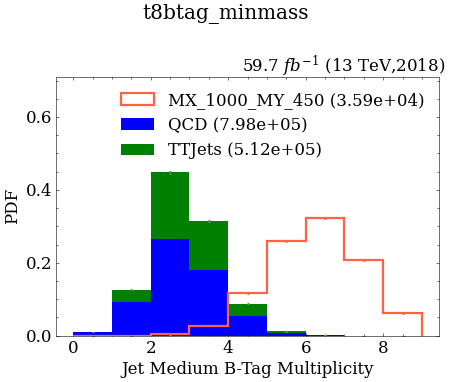

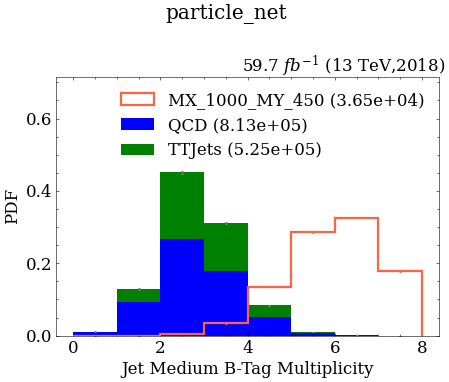

In [10]:
for i,title in enumerate(labels):
  study.quick(
    signals[[i]]+qcds[[i]]+ttbars[[i]], stacked=True,
    varlist=['n_medium_btag'],
    legend=True, 
    title=title,
    density=True,
    # saveas=f'{dout}/{title}_medium_btag'
  )

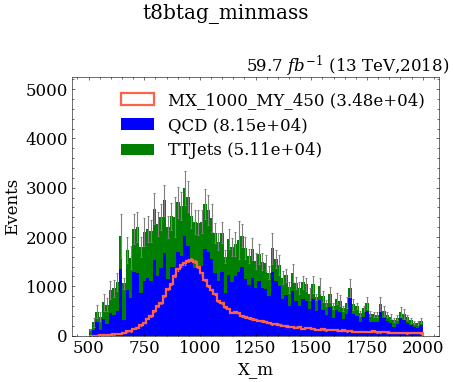

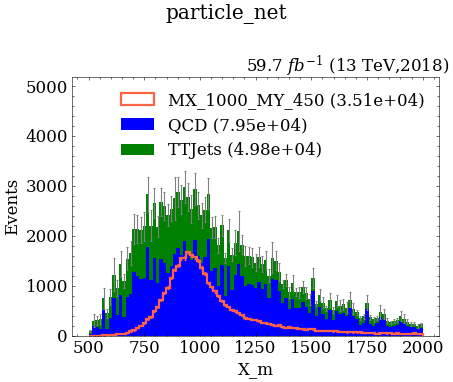

In [23]:
for i,title in enumerate(labels):
  study.quick(
    signals[[i]]+qcds[[i]]+ttbars[[i]], stacked=True,
    masks=lambda t:(t.n_medium_btag > 3),
    varlist=['X_m'],
    binlist=[np.linspace(500,2000,100)],
    legend=True, 
    title=title,
    h_restrict=True,
    saveas=f'{dout}/{title}_limit_input_baseline'
  )

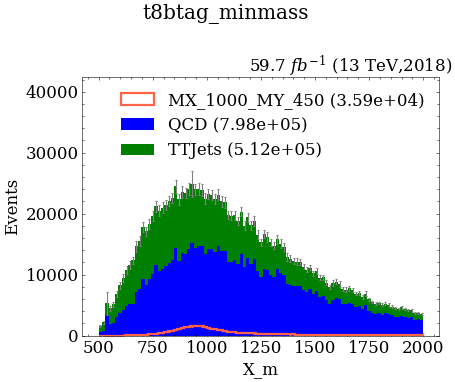

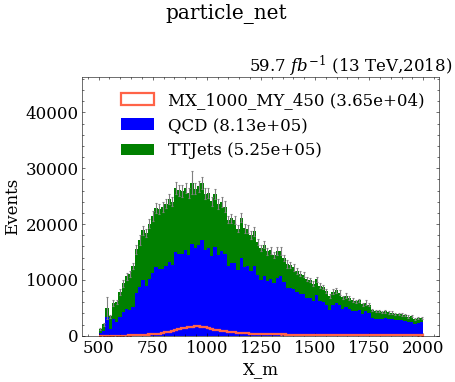

In [12]:
for i,title in enumerate(labels):
  study.quick(
    signals[[i]]+qcds[[i]]+ttbars[[i]], stacked=True,
    # masks=lambda t:(t.n_medium_btag > 4),
    varlist=['X_m'],
    binlist=[np.linspace(500,2000,100)],
    legend=True, 
    title=title,
    h_restrict=True,
    # saveas=f'{dout}/{title}_X_m'
  )

In [13]:
class print_cut_info(ObjTransform):
  def __call__(self, tree):
    mask = self.cut(tree)
    lumi,_ = lumiMap[2018]

    scale = lumi*tree.scale

    total = ak.sum(scale)
    after = ak.sum(scale[mask])
    eff = after/total 
    print(f'{after:0.3f}',f'{eff:0.3f}')
(signals+bkgs).apply(print_cut_info(cut=lambda t:t.n_medium_btag>3))


34806.914 0.969
35079.925 0.961
81513.187 0.102
79499.967 0.098
51057.269 0.100
49793.162 0.095


[None, None, None, None, None, None]

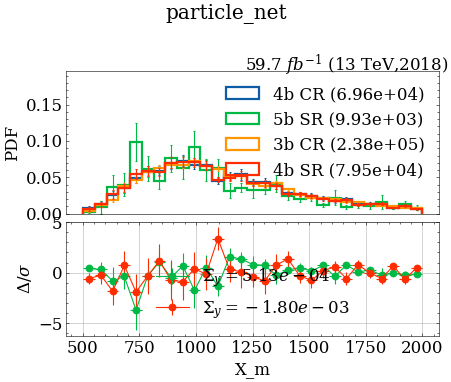

In [32]:
study.quick(
    qcds[[1,1,1,1]],h_color=None,label=['4b CR','5b SR','3b CR', '4b SR'],
    masks=[lambda t:(t.n_medium_btag == 4),lambda t:(t.n_medium_btag>4),lambda t:(t.n_medium_btag == 3),lambda t:(t.n_medium_btag>3)],
    varlist=[ 'X_m' ],
    legend=True, density=True,
    title=title, 

    difference=True, d_legend=True, d_size='80%', d_ylim=None, d_label_stat='y_sum', d_method='standardize', d_group=[(0,1),(2,3)]
  )

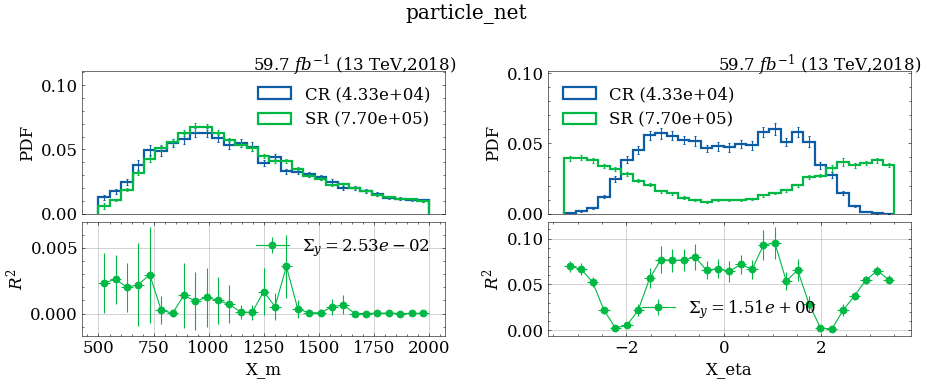

In [15]:
study.quick(
    qcds[[1,1,1,1]],h_color=None,label=['CR','SR'],
    masks=[lambda t:(t.X_pt>250),lambda t:(t.X_pt<250)],
    varlist=[ 'X_m','X_eta' ],
    legend=True, density=True,
    title=title, 

    difference=True, d_legend=True, d_size='80%', d_ylim=None, d_label_stat='y_sum', d_method='r2'
  )

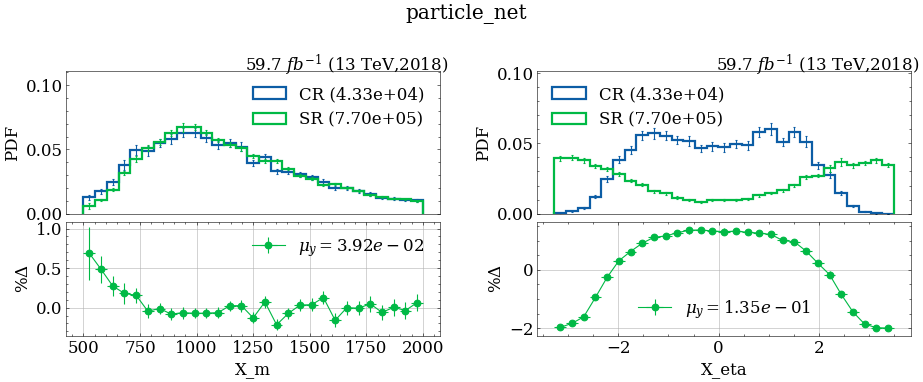

In [16]:
study.quick(
    qcds[[1,1,1,1]],h_color=None,label=['CR','SR'],
    masks=[lambda t:(t.X_pt>250),lambda t:(t.X_pt<250)],
    varlist=[ 'X_m','X_eta' ],
    legend=True, density=True,
    title=title, 

    difference=True, d_legend=True, d_size='80%', d_ylim=None, d_label_stat='y_mean', d_method='normalize'
  )

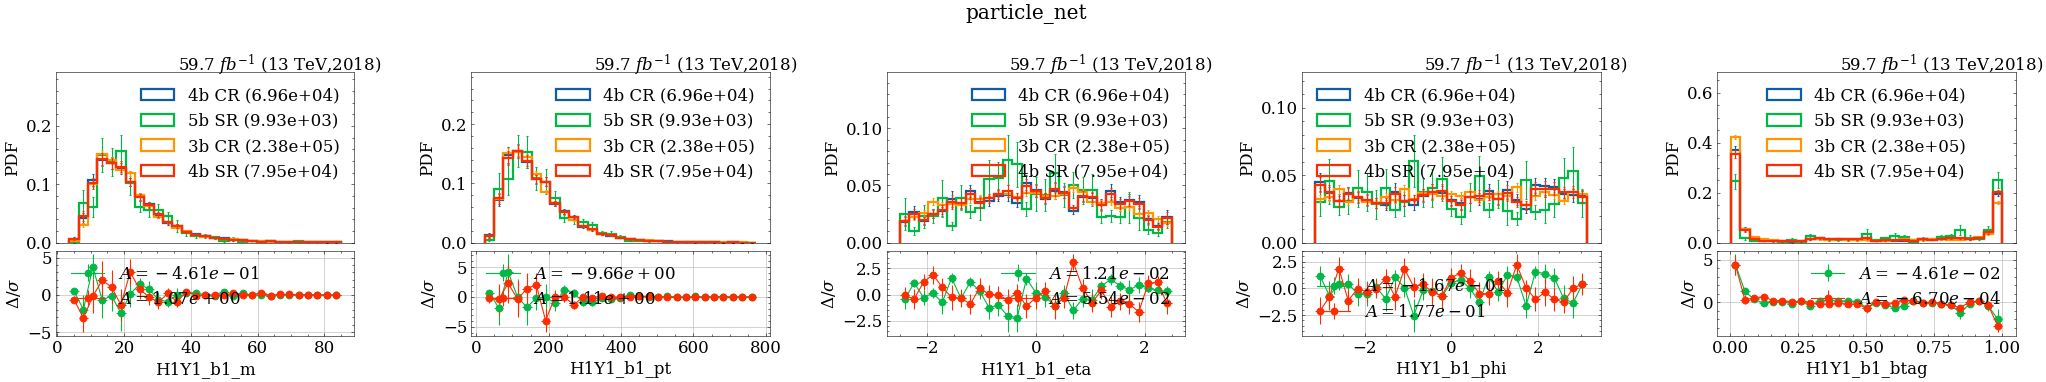

In [17]:
# for obj in ['X']+eightb.ylist+eightb.higgslist+eightb.quarklist:
for obj in eightb.quarklist:
  varlist = ['m','pt','eta','phi']
  if obj in eightb.quarklist: varlist.append('btag')
  study.quick(
    qcds[[1,1,1,1]],h_color=None,label=['4b CR','5b SR','3b CR', '4b SR'],
    masks=[lambda t:(t.n_medium_btag == 4),lambda t:(t.n_medium_btag>4),lambda t:(t.n_medium_btag == 3),lambda t:(t.n_medium_btag>3)],
    varlist=[f'{obj}_{var}'for var in  varlist ],
    legend=True, density=True,
    title=title, dim=(-1, len(varlist)),

    difference=True, d_legend=True, d_size='50%', d_ylim=None, d_label_stat='area', d_method='standardize', d_group=[(0,1),(2,3)]
    # ratio=True, r_legend=True, r_label_stat='y_std', r_size='50%'
  )
  break

(<Figure size 468x468 with 1 Axes>,
 <AxesSubplot:ylabel='$\\frac{(sr - cr)}{\\sigma(sr-cr)}$'>)

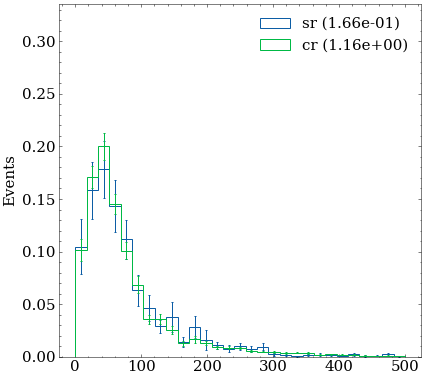

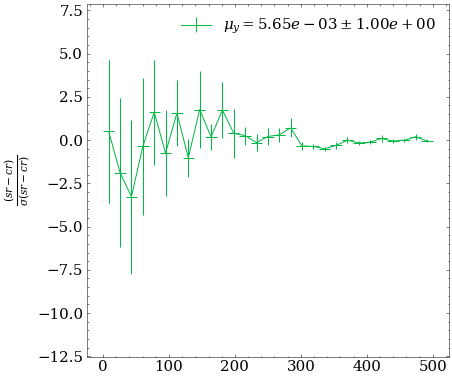

In [18]:
tree = qcds[1]
scale = tree.scale
cr_mask = tree.n_medium_btag == 4
sr_mask = tree.n_medium_btag >  4

# var = 'X_m'
# bins=np.linspace(500,2000,30)

var = 'X_pt'
bins=np.linspace(0,500,30)

cr_var, cr_scale = tree[var][cr_mask], scale[cr_mask]
sr_var, sr_scale = tree[var][sr_mask], scale[sr_mask]

sr_histo = Histo(sr_var, bins=bins, weights=sr_scale, density=True, histtype='step', label='sr')
cr_histo = Histo(cr_var, bins=bins, weights=cr_scale, density=True, histtype='step', label='cr')
plot_histos([sr_histo, cr_histo], legend=True)

chi2 = Difference(sr_histo, cr_histo, method='standardize', label_stat='y_mean_std')
plot_graph(chi2, legend=True, ylabel='$\\frac{(sr - cr)}{\sigma(sr-cr)}$')


In [19]:
np.mean(chi2.y_array), np.std(chi2.y_array)

(0.005648533276289869, 1.0000000000000002)

(<Figure size 468x468 with 1 Axes>, <AxesSubplot:ylabel='Events'>)

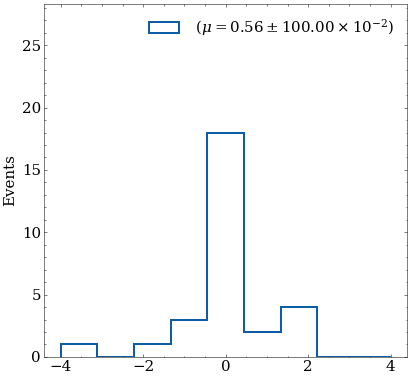

In [20]:
hist_multi([chi2.y_array], h_label_stat='mean_stdv', legend=True, errors=False, bins=np.linspace(-4,4,10))

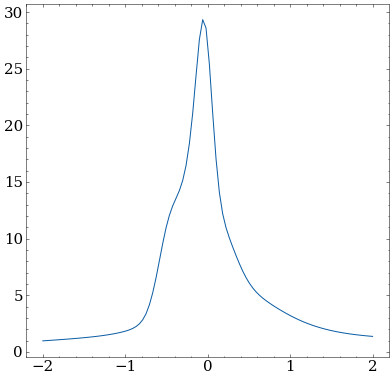

In [21]:
from scipy import stats 

n = 100
x = np.linspace(-2,2,n)
y = np.zeros(n)
for mean, error in zip(chi2.y_array, chi2.yerr):
  y += scipy.stats.norm(mean, error).pdf(x)

plt.plot(x, y)

6.032927576424812